In [1]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations, chain  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
import xml.etree.ElementTree as ET # for parse the SBML file
import seaborn as sns # for plotting
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from matplotlib.gridspec import GridSpec

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-01-01`

In [2]:
# Read the data
mutations = pd.read_csv("./Data/BeatAML/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("./Data/BeatAML/beataml_wv1to4_clinical.xlsx")
classification = pd.read_csv("./Palma2021/class.csv")
df_drugs = pd.read_csv('./Data/BeatAML/drug_gene.csv', usecols=['inhibitor', 'Symbol'])
drugs = pd.read_csv('./Data/BeatAML/beataml_probit_curve_fits_v4_dbgap.txt', sep='\t')
print("# of samples per drug:")
print(drugs['inhibitor'].value_counts())

palma = biolqm.load("./Models/Palma2021_nophe.sbml")
ikonomi = biolqm.load("./Models/Ikonomi2020_updated.sbml")
merged_and = biolqm.load("./Models/merged_and.sbml")
merged_inhibitor_wins = biolqm.load("./Models/merged_inhibitor_wins.sbml")
merged_or = biolqm.load("./Models/merged_or.sbml")

# of samples per drug:
inhibitor
Imatinib                   614
Sorafenib                  598
Dasatinib                  598
Sunitinib                  595
Trametinib (GSK1120212)    581
                          ... 
SU14813                      3
PRT062070                    3
AST-487                      3
AKT Inhibitor X              3
Everolimus                   3
Name: count, Length: 166, dtype: int64


In [3]:
# Only use de novo samples for drug data

clinical_filtered = clinical[clinical['isDenovo'] == 'TRUE']
unique_dnaseq_samples = set(clinical_filtered['dbgap_dnaseq_sample'].dropna().unique())
unique_rnaseq_samples = set(clinical_filtered['dbgap_rnaseq_sample'].dropna().unique())
unique_samples = unique_dnaseq_samples.union(unique_rnaseq_samples)

drugs_filtered = drugs[drugs['dbgap_dnaseq_sample'].isin(unique_samples) | 
                       drugs['dbgap_rnaseq_sample'].isin(unique_samples)]
print("# of de novo samples per drug:")
print(drugs_filtered['inhibitor'].value_counts())
drugs_filtered

# of de novo samples per drug:
inhibitor
Imatinib                   272
Trametinib (GSK1120212)    267
Sorafenib                  262
Sunitinib                  262
Dasatinib                  261
                          ... 
AST-487                      1
AKT Inhibitor X              1
SU14813                      1
PRT062070                    1
Everolimus                   1
Name: count, Length: 166, dtype: int64


,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,type,status,paper_inclusion,min_conc,max_conc,intercept,beta,beta_z,beta_p,aic,pearson_chisq,deviance,converged,ic10,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type
355,2418,NaN,BA2409R,A-674563,single-agent,train/test,True,0.01370,10,0.068196,-0.636974,-1.114117,0.265229,10.079571,1.440730e+00,1.788883e+00,True,0.013700,0.111729,1.279564,10.000000,10.000000,177.042163,False,False,decreasing
356,2418,NaN,BA2409R,AKT Inhibitor IV,single-agent,exploratory,True,0.03430,25,0.281281,-1.439688,-1.612883,0.106770,6.670427,6.778271e-01,5.875253e-01,True,0.201937,0.533186,1.568207,4.611831,12.176864,165.026475,False,False,decreasing
357,2418,NaN,BA2409R,AKT Inhibitor X,single-agent,exploratory,True,0.06860,50,1.970532,0.365132,0.294259,0.768560,4.361888,1.781048e-01,2.202131e-01,True,50.000000,50.000000,50.000000,50.000000,50.000000,279.449844,True,False,increasing
358,2418,NaN,BA2409R,AMPK Inhibitor,single-agent,exploratory,True,0.01370,10,1.300077,-0.218180,-0.297683,0.765945,5.269871,5.856839e-01,6.493027e-01,True,1.215894,10.000000,10.000000,10.000000,10.000000,261.982907,True,False,decreasing
359,2418,NaN,BA2409R,AST-487,single-agent,exploratory,True,0.01370,10,2.658004,-0.205331,-0.084334,0.932791,4.049205,5.206412e-02,5.440116e-02,True,10.000000,10.000000,10.000000,10.000000,10.000000,285.359954,True,False,decreasing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63390,2750,BA3100D,NaN,Venetoclax,single-agent,combined,True,0.01370,10,-1.207029,-0.552443,-0.842753,0.399367,7.286196,3.446185e-01,3.701995e-01,True,0.013700,0.013700,0.013700,0.108646,1.364257,54.410634,False,True,decreasing
63391,2750,BA3100D,NaN,Vismodegib (GDC-0449),single-agent,train/test,True,0.01370,10,11.338225,-9.798777,-0.000763,0.999391,4.127685,2.503099e-10,5.006199e-10,True,10.000000,10.000000,10.000000,10.000000,10.000000,286.054744,True,False,decreasing
63392,2750,BA3100D,NaN,Volasertib (BI-6727),single-agent,combined,True,0.01370,10,-0.704943,-0.646073,-1.111532,0.266339,8.902190,1.152906e+00,1.199744e+00,True,0.013700,0.013700,0.081074,0.897093,7.806963,101.568804,False,False,decreasing
63393,2750,BA3100D,NaN,XMD 8-87,single-agent,exploratory,True,0.01370,10,-0.263175,0.083194,0.164553,0.869296,11.602969,1.314956e-01,1.304616e-01,True,0.013700,0.013700,0.013700,10.000000,10.000000,109.579679,False,True,increasing


In [4]:
# Get genes in each model
def getnodes(model_name):
    # Load and parse the SBML file
    tree = ET.parse("./Models/" + model_name + ".sbml")
    root = tree.getroot()
    
    # Define the namespace for SBML Level 3 Version 1 Core and Qual
    ns = {
        'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
        'qual': 'http://www.sbml.org/sbml/level3/version1/qual/version1'
    }
    
    # Find all qualitativeSpecies in the model
    qual_species_list = root.findall('.//qual:qualitativeSpecies', ns)
    
    # Extract the IDs of the qualitativeSpecies
    qual_species_ids = []
    for species in qual_species_list:
        species_id = species.attrib.get('{http://www.sbml.org/sbml/level3/version1/qual/version1}id')
        if species_id:
            qual_species_ids.append(species_id)

    print(qual_species_ids)
    return qual_species_ids
    
gene_palma = getnodes("Palma2021_nophe")
gene_ikonomi = getnodes("Ikonomi2020_updated")
gene_merged = list(set(gene_palma + gene_ikonomi))

# Count the number of unique patients with mutations in each gene
drug_palma = df_drugs[df_drugs['Symbol'].isin(gene_palma)].copy()
drug_ikonomi = df_drugs[df_drugs['Symbol'].isin(gene_ikonomi)].copy()

drug_palma['Palma'] = 1
drug_ikonomi['Ikonomi'] = 1
combined_df = pd.concat([drug_palma, drug_ikonomi])

# Group by 'inhibitor' and 'Symbol', and aggregate by max to indicate presence
combined_df = combined_df.groupby(['inhibitor', 'Symbol'], as_index=False).max()

combined_df = combined_df.fillna(0)
combined_df[['Palma', 'Ikonomi']] = combined_df[['Palma', 'Ikonomi']].astype(int)
combined_df

['AKT1', 'CDKN2A', 'BCL2', 'CCND1', 'CEBPA', 'DNMT3A', 'MAPK1', 'ETV6', 'FBXW7', 'FLT3', 'GSK3B', 'HOXA9', 'MEIS1', 'MYC', 'NPM1', 'SOX4', 'STAT5A', 'TP53']
['External_quiescence', 'External_cycling', 'PIK3CA', 'TSC1', 'MTOR', 'FOXO3', 'ATM', 'ROS1', 'Mitochondria', 'Autophagy', 'ERAS', 'ETS1', 'MEFV', 'GSK3B', 'CTNNB1', 'MYC', 'BMI1', 'MDM2', 'TP53', 'CDKN1C', 'CDKN1A', 'CDKN1B', 'GFI1', 'RB1', 'E2F1', 'CCND1', 'CCNE1', 'S_phase', 'AKT1', 'CDKN2D', 'CDKN2A', 'Pro_apoptotic_proteins', 'Anti_apoptotic_proteins', 'CYCS', 'Apoptosis', 'Senescence']


,inhibitor,Symbol,Palma,Ikonomi
0,ABT-737,BCL2,1,0
1,AKT Inhibitor IV,AKT1,1,1
2,AKT Inhibitor X,AKT1,1,1
3,AST-487,FLT3,1,0
4,AT7519,GSK3B,1,1
5,AZD1152-HQPA (AZD2811),FLT3,1,0
6,BEZ235,MTOR,0,1
7,BEZ235,PIK3CA,0,1
8,CHIR-99021,GSK3B,1,1
9,Crenolanib,FLT3,1,0


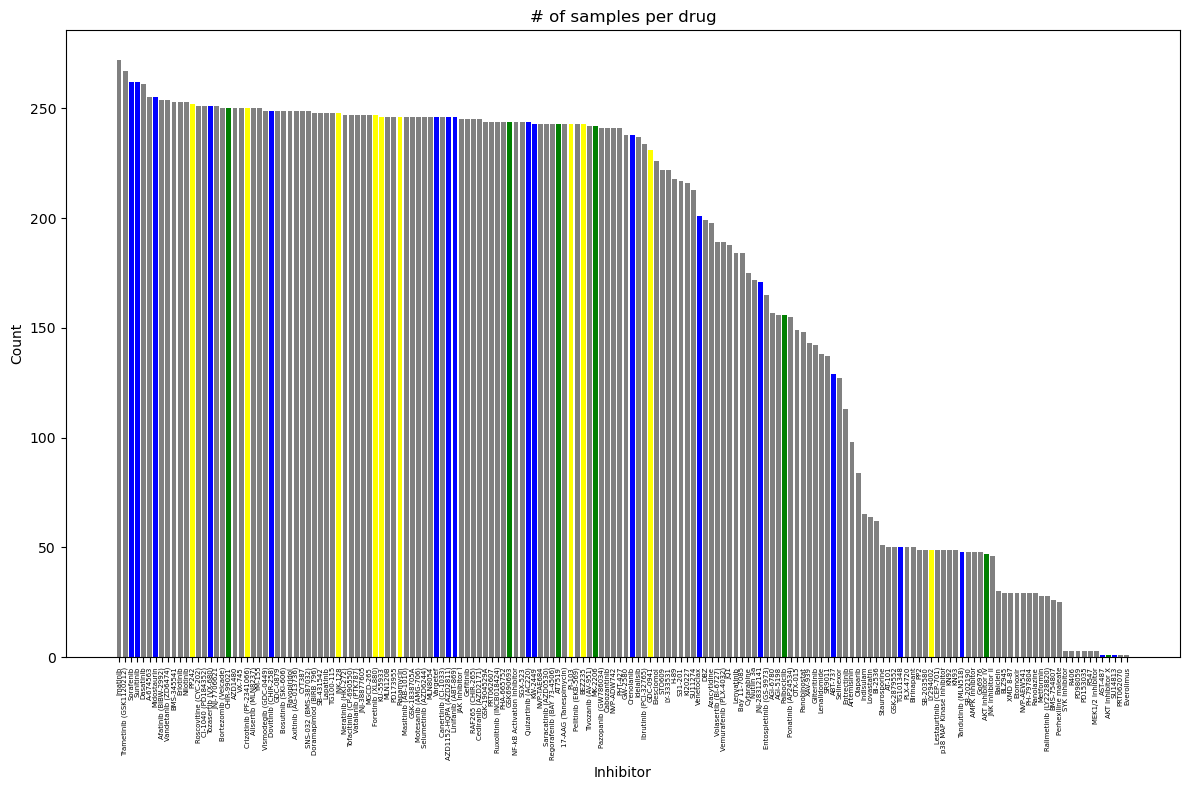

In [5]:
drugs = drugs_filtered.copy()
inhibitor_counts = pd.DataFrame(drugs['inhibitor'].value_counts().sort_values(ascending=False))

grouped = inhibitor_counts.merge(combined_df, on = 'inhibitor', how = 'left')
grouped['color'] = 'gray'  # Default color

# Assign colors based on conditions
grouped.loc[(grouped['Palma'] > 0) & (grouped['Ikonomi'] == 0), 'color'] = 'blue'
grouped.loc[(grouped['Palma'] == 0) & (grouped['Ikonomi'] > 0), 'color'] = 'yellow'
grouped.loc[(grouped['Palma'] > 0) & (grouped['Ikonomi'] > 0), 'color'] = 'green'

# Sort inhibitors by count
grouped_sorted = grouped.sort_values(by='count', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(grouped_sorted['inhibitor'], grouped_sorted['count'], color=grouped_sorted['color'])

# Improve layout for readability
plt.xticks(rotation=90, fontsize=5)
plt.xlabel('Inhibitor')
plt.ylabel('Count')
plt.title('# of samples per drug')
plt.tight_layout()

plt.show()

In [6]:
# ________________________________________________________________________The Palma model
palma_drug_df = combined_df[combined_df['Palma']==1]

# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = palma_drug_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()

def generate_perturbation(mutations):
    perturbations = []
    for mutation in mutations:
        perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)
    
inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(palma, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
inhibitor_to_symbols['palma_network_score'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'palma_network_score']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(palma)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['palma_network_score'].isna() | (drugs['palma_network_score'] == ''), 'palma_network_score'] = network_score_wt

# ________________________________________________________________________ the merged model - AND
# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = combined_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()

inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
inhibitor_to_symbols['merged_and_network_score'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'merged_and_network_score']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['merged_and_network_score'].isna() | (drugs['merged_and_network_score'] == ''), 'merged_and_network_score'] = network_score_wt

# ________________________________________________________________________the merged model - Inhibitor wins
perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
inhibitor_to_symbols['merged_inhibitor_wins_network_score'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'merged_inhibitor_wins_network_score']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['merged_inhibitor_wins_network_score'].isna() | (drugs['merged_inhibitor_wins_network_score'] == ''), 'merged_inhibitor_wins_network_score'] = network_score_wt

# ________________________________________________________________________the merged model - OR
# Generate unique mutation profiles and their perturbation strings
perturbation_to_scores = {}

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

print(perturbation_to_scores)

# Merge the df
inhibitor_to_symbols['merged_or_network_score'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'merged_or_network_score']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs.loc[drugs['merged_or_network_score'].isna() | (drugs['merged_or_network_score'] == ''), 'merged_or_network_score'] = network_score_wt

{'BCL2%0': 0.0, 'AKT1%0': 0.0, 'FLT3%0': 0.0, 'GSK3B%0': 1.0, 'CCND1%0': 0.0}
{'BCL2%0': 0.28205128205128205, 'AKT1%0': 0.8, 'FLT3%0': -1.6, 'GSK3B%0': 0.5263157894736841, 'PIK3CA%0 MTOR%0': 0.8, 'ROS1%0': 0.9361702127659575, 'ROS1%0 FLT3%0': -1.5, 'PIK3CA%0': 0.8, 'MTOR%0': 0.6153846153846153, 'ATM%0': 0.41025641025641024, 'CCND1%0': 0.7}
{'BCL2%0': 0.1428571428571428, 'AKT1%0': 0.25, 'FLT3%0': -1.9411764705882353, 'GSK3B%0': 0.44444444444444453, 'PIK3CA%0 MTOR%0': 0.47058823529411775, 'ROS1%0': 0.935483870967742, 'ROS1%0 FLT3%0': -1.352941176470588, 'PIK3CA%0': 0.47058823529411775, 'MTOR%0': 0.4285714285714284, 'ATM%0': 0.31428571428571406, 'CCND1%0': 0.5789473684210528}
{'BCL2%0': -0.1428571428571428, 'AKT1%0': -0.46666666666666656, 'FLT3%0': -1.9375, 'GSK3B%0': 0.26923076923076916, 'PIK3CA%0 MTOR%0': -0.3214285714285713, 'ROS1%0': 0.1538461538461542, 'ROS1%0 FLT3%0': -1.9285714285714288, 'PIK3CA%0': -0.3214285714285713, 'MTOR%0': 1.1102230246251565e-16, 'ATM%0': 1.1102230246251565e

In [7]:
%run 'ProxPath.ipynb'

# the Palma results
pheno_palma = proxpath(gene_palma)

# Calculate the phenotype score
perturbation_to_scores_proxypath = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_palma_unique = pheno_palma.drop_duplicates(subset=['QueryNode', 'EndNode'])

# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = palma_drug_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()
inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(palma, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']               
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
inhibitor_to_symbols['palma_network_score_proxypath'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores_proxypath)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'palma_network_score_proxypath']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(palma)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['palma_network_score_proxypath'].isna() | (drugs['palma_network_score_proxypath'] == ''), 'palma_network_score_proxypath'] = results.loc['NETWORK'].item()

# Calculate the phenotype score
pheno_merged = proxpath(gene_merged)
perturbation_to_scores_proxypath = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_merged_unique = pheno_merged.drop_duplicates(subset=['QueryNode', 'EndNode'])

# Generate unique mutation profiles and their perturbation strings
inhibitor_to_symbols = combined_df.groupby('inhibitor')['Symbol'].apply(set).reset_index()

inhibitor_to_symbols['perturbation_string'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
unique_perturbations = inhibitor_to_symbols['perturbation_string'].unique()

#___________________ merged_and _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
inhibitor_to_symbols['merged_and_network_score_proxypath'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores_proxypath)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'merged_and_network_score_proxypath']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['merged_and_network_score_proxypath'].isna() | (drugs['merged_and_network_score_proxypath'] == ''), 'merged_and_network_score_proxypath'] = results.loc['NETWORK'].item()

#___________________ merged_inhibitor_wins _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
inhibitor_to_symbols['merged_inhibitor_wins_network_score_proxypath'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores_proxypath)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'merged_inhibitor_wins_network_score_proxypath']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['merged_inhibitor_wins_network_score_proxypath'].isna() | (drugs['merged_inhibitor_wins_network_score_proxypath'] == ''), 'merged_inhibitor_wins_network_score_proxypath'] = results.loc['NETWORK'].item()

#___________________ merged_or _________________
for perturbation in unique_perturbations:
    if perturbation: 
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
inhibitor_to_symbols['merged_or_network_score_proxypath'] = inhibitor_to_symbols['perturbation_string'].map(perturbation_to_scores_proxypath)
drugs = drugs.merge(inhibitor_to_symbols[['inhibitor', 'merged_or_network_score_proxypath']], on='inhibitor', how='left')

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs.loc[drugs['merged_or_network_score_proxypath'].isna() | (drugs['merged_or_network_score_proxypath'] == ''), 'merged_or_network_score_proxypath'] = results.loc['NETWORK'].item()

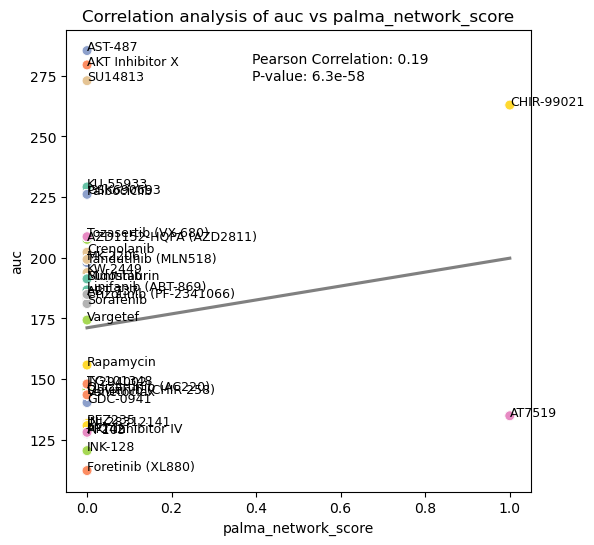

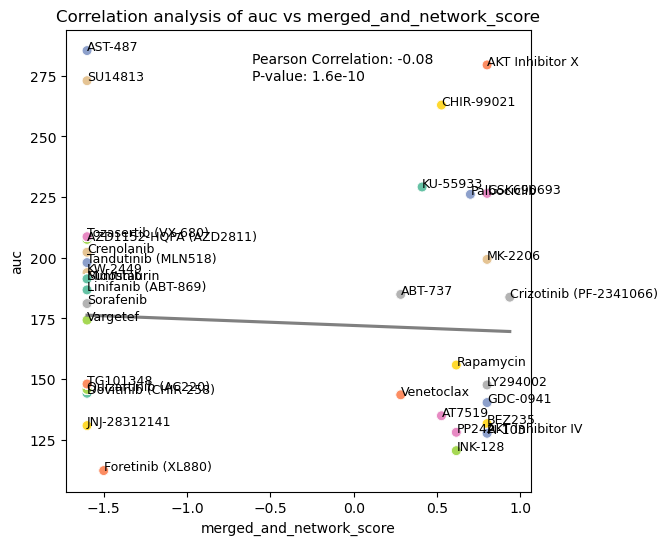

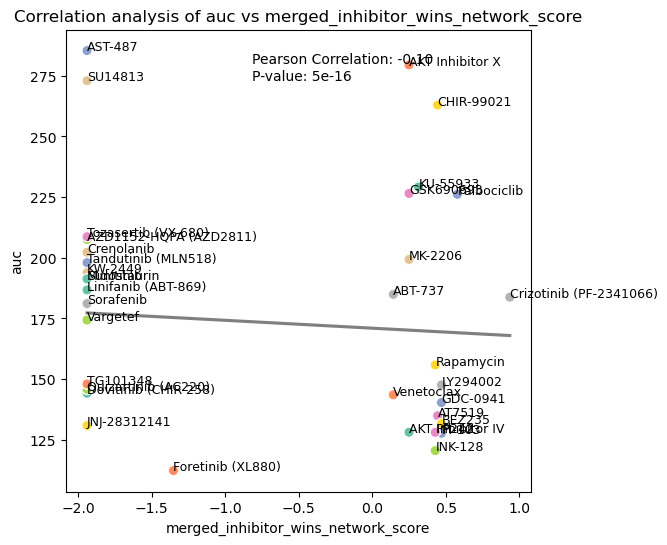

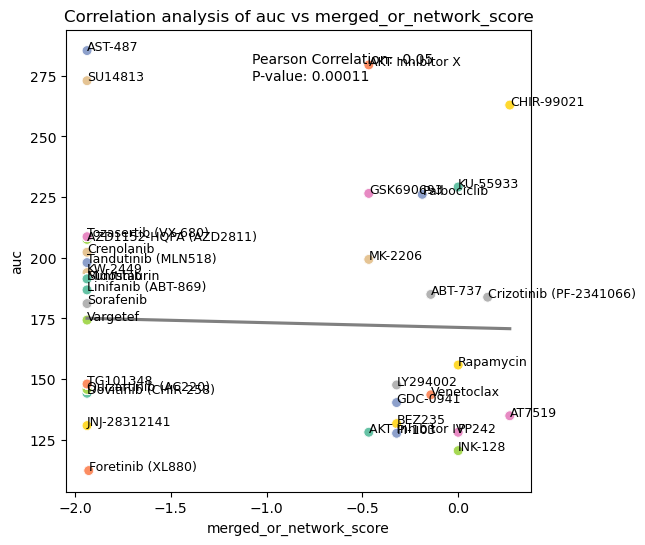

In [8]:
def correlation_plot_drug(pheno, drug_variable):
    df = drugs[drugs['inhibitor'].isin(combined_df['inhibitor'])].copy()

    # Convert clinical_variable to numeric, coercing errors to NaN
    df[drug_variable] = pd.to_numeric(df[drug_variable], errors='coerce')

    # Aggregate the data to calculate mean AUC for each drug
    mean_auc_per_drug = df.groupby('inhibitor')['auc'].mean().reset_index()
    
    # Merge the averaged AUC back into the original DataFrame
    aggregated_df = df.drop('auc', axis=1).drop_duplicates().merge(mean_auc_per_drug, on='inhibitor')

    # Drop rows where either drug_variable or pheno is NaN
    aggregated_df = aggregated_df.dropna(subset=[drug_variable, pheno])
    
    if len(aggregated_df) > 1:  # Ensure there are at least 2 data points
        pc, p_value = pearsonr(aggregated_df[drug_variable], aggregated_df[pheno])
    
        # Plotting
        plt.figure(figsize=(6, 6))
        
        # Plot the regression line
        sns.regplot(x=pheno, y=drug_variable, data=aggregated_df, ci=None, scatter=False, color='gray', label='Regression Line')
        
        # Plot points with colors based on 'inhibitors' 
        sns.scatterplot(data=aggregated_df, x=pheno, y=drug_variable, hue='inhibitor', palette='Set2', s=50, alpha=1, legend=False)
        
        # Handle annotations
        for inhibitor, group in aggregated_df.groupby('inhibitor'):
            # Select a representative point for annotation (e.g., mean values of the group)
            mean_pheno = group[pheno].mean()
            mean_drug_variable = group[drug_variable].mean()
            plt.annotate(inhibitor, (mean_pheno, mean_drug_variable), fontsize=9)
                
        plt.title('Correlation analysis of ' + drug_variable + ' vs ' + pheno)
        plt.xlabel(pheno)
        plt.ylabel(drug_variable)
        # Annotating the plot with Pearson Correlation and p-value
        plt.text(0.4, 0.95, f'Pearson Correlation: {pc:.2f}\nP-value: {p_value:.2g}', transform=plt.gca().transAxes, verticalalignment='top')
    
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

correlation_plot_drug('palma_network_score', 'auc')
correlation_plot_drug('merged_and_network_score', 'auc')
correlation_plot_drug( 'merged_inhibitor_wins_network_score', 'auc')
correlation_plot_drug('merged_or_network_score', 'auc')

# Consider patient mutations

In [9]:
clinical_df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
# mutations_df = clinical_df[
#     (clinical_df['symbol'].isin(gene_palma)) &
#     (
#         # Apply 'sift' and 'polyphen' filters only for 'missense_variant'
#         ((clinical_df['variant_classification'] == 'missense_variant') &
#          (clinical_df['sift'].str.startswith('deleterious')) &
#          (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging'))))
#         |
#         # For other 'variant_classification' values, do not filter by 'sift' and 'polyphen'
#         (clinical_df['variant_classification'] != 'missense_variant')
#     )
# ]
mutations_df = clinical_df[clinical_df['symbol'].isin(gene_palma)]
patient_to_mutations = mutations_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()

# Generate unique mutation profiles and their perturbation strings
classification_dict = classification.set_index('symbol')['class'].to_dict()

# def generate_perturbation_string(mutations):
#     perturbations = []
#     for mutation in mutations:
#         class_type = classification_dict.get(mutation)
#         if class_type == 'oncogene':
#             perturbations.append(f"{mutation}%1")
#         elif class_type == 'TSG':
#             perturbations.append(f"{mutation}%0")
#     return " ".join(perturbations)

def generate_perturbation_string(mutations):
    perturbations = []
    for mutation in mutations:
        perturbations.append(f"{mutation}%0")
    return " ".join(perturbations)
    
patient_to_mutations['perturbation_string'] = patient_to_mutations['symbol'].apply(generate_perturbation_string)
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')

mutations_df = mutations_df.copy()
# mapping dbgap_subject_id to symbol (mutation profile)
subject_to_symbol = patient_to_mutations[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
mutations_df['mutation_profile_palma'] = mutations_df['dbgap_subject_id'].map(subject_to_symbol)

# mapping dbgap_subject_id to pertubation string
subject_to_pertstr = patient_to_mutations[['dbgap_subject_id', 'perturbation_string']].set_index('dbgap_subject_id').to_dict()['perturbation_string']
mutations_df['perturbation_string_palma'] = mutations_df['dbgap_subject_id'].map(subject_to_pertstr)

# Update 'mutation_profile' to 'wildtype' where it is blank or NaN
mutations_df.loc[mutations_df['mutation_profile_palma'].isna() | (mutations_df['mutation_profile_palma'] == ''), 'mutation_profile_palma'] = 'wildtype'

# ________________________________ for the merged model
# merged_df = clinical_df[
#     (clinical_df['symbol'].isin(gene_merged)) &
#     (
#         # Apply 'sift' and 'polyphen' filters only for 'missense_variant'
#         ((clinical_df['variant_classification'] == 'missense_variant') &
#          (clinical_df['sift'].str.startswith('deleterious')) &
#          (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging'))))
#         |
#         # For other 'variant_classification' values, do not filter by 'sift' and 'polyphen'
#         (clinical_df['variant_classification'] != 'missense_variant')
#     )
# ]
merged_df = clinical_df[clinical_df['symbol'].isin(gene_merged)]
patient_to_mutations = merged_df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()
classification_dict = classification.set_index('symbol')['class'].to_dict()
patient_to_mutations['perturbation_string'] = patient_to_mutations['symbol'].apply(generate_perturbation_string)
patient_to_mutations['symbol'] = patient_to_mutations['symbol'].str.join(', ')

merged_df = merged_df.copy()
# mapping dbgap_subject_id to pertubation string
subject_to_pertstr = patient_to_mutations[['dbgap_subject_id', 'perturbation_string']].set_index('dbgap_subject_id').to_dict()['perturbation_string']
merged_df['perturbation_string_merged'] = mutations_df['dbgap_subject_id'].map(subject_to_pertstr)

# mapping dbgap_subject_id to symbol (mutation profile)
subject_to_symbol = patient_to_mutations[['dbgap_subject_id', 'symbol']].set_index('dbgap_subject_id').to_dict()['symbol']
merged_df['mutation_profile_merged'] = merged_df['dbgap_subject_id'].map(subject_to_symbol)

# Update 'mutation_profile' to 'wildtype' where it is blank or NaN
merged_df.loc[merged_df['mutation_profile_merged'].isna() | (merged_df['mutation_profile_merged'] == ''), 'mutation_profile_merged'] = 'wildtype'

# merge the Palma model scores and merged model scores
merged_df = merged_df[['dbgap_subject_id','mutation_profile_merged', 'perturbation_string_merged']]
mutations_df = mutations_df.merge(merged_df, on='dbgap_subject_id', how='left')
mutations_df

,dbgap_sample_id,capture_type,seqnames,pos_start,pos_end,ref,alt,genotyper,tumor_only,total_reads,allele_reads,normal_total_reads,normal_allele_reads,t_vaf,n_vaf,variant_classification,hgvsp_short,gene,symbol,biotype,hgvsc,hgvsp,cdna_position,cds_position,protein_position,amino_acids,codons,existing_variation,refseq,sift,polyphen,exac_af,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,cohort,used_manuscript_analyses,manuscript_dnaseq,manuscript_rnaseq,manuscript_inhibitor,consensus_sex,inferred_sex,reportedRace,reportedEthnicity,inferred_ethnicity,centerID,CEBPA_Biallelic,consensusAMLFusions,ageAtDiagnosis,isRelapse,isDenovo,isTransformed,specificDxAtAcquisition_MDSMPN,nonAML_MDSMPN_specificDxAtAcquisition,priorMalignancyNonMyeloid,priorMalignancyType,cumulativeChemo,priorMalignancyRadiationTx,priorMDS,priorMDSMoreThanTwoMths,priorMDSMPN,priorMDSMPNMoreThanTwoMths,priorMPN,priorMPNMoreThanTwoMths,dxAtInclusion,specificDxAtInclusion,ELN2017,dxAtSpecimenAcquisition,specificDxAtAcquisition,ageAtSpecimenAcquisition,timeOfSampleCollectionRelativeToInclusion,specimenGroups,diseaseStageAtSpecimenCollection,specimenType,rnaSeq,exomeSeq,totalDrug,analysisRnaSeq,analysisExomeSeq,analysisDrug,cumulativeTreatmentTypeCount,cumulativeTreatmentTypes,cumulativeTreatmentRegimenCount,cumulativeTreatmentRegimens,cumulativeTreatmentStageCount,cumulativeTreatmentStages,responseToInductionTx,typeInductionTx,responseDurationToInductionTx,mostRecentTreatmentType,currentRegimen,currentStage,mostRecentTreatmentDuration,vitalStatus,overallSurvival,causeOfDeath,%.Basophils.in.PB,%.Blasts.in.BM,%.Blasts.in.PB,%.Eosinophils.in.PB,%.Immature.Granulocytes.in.PB,%.Lymphocytes.in.PB,%.Monocytes.in.PB,%.Neutrophils.in.PB,%.Nucleated.RBCs.in.PB,ALT,AST,albumin,creatinine,fabBlastMorphology,hematocrit,hemoglobin,karyotype,LDH,MCV,otherCytogenetics,plateletCount,surfaceAntigensImmunohistochemicalStains,totalProtein,wbcCount,FLT3-ITD,allelic_ratio,NPM1,RUNX1,ASXL1,TP53,variantSummary,mutation_profile_palma,perturbation_string_palma,mutation_profile_merged,perturbation_string_merged
0,BA2336D,NexteraV1.2,5,170837543,170837543,C,CTCTG,varscan,1,59,17,0,0,0.288136,0.0,frameshift_variant,p.W288Cfs*12,ENSG00000181163,NPM1,protein_coding,ENST00000296930.5:c.860_863dupTCTG,ENSP00000296930.5:p.Trp288CysfsTer12,1160-1161/1758,859-860/885,287/294,L/LCX,ctc/cTCTGtc,rs758959453&COSM158604,NM_002520.6,NaN,NaN,0.000008,2030,BA2336D,NaN,Waves1+2,yes,yes,no,no,Male,Male,White,NON-HISPANIC,White,1,NaN,NaN,73.0,FALSE,TRUE,FALSE,False,False,n,NaN,y,n,n,n,n,n,n,n,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,AML with mutated NPM1,FavorableOrIntermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,AML with mutated NPM1,73.0,1,Initial Acute Leukemia Diagnosis,Initial Diagnosis,Bone Marrow Aspirate,n,y,n,n,y,n,2.0,Standard Chemotherapy|Targeted Therapy - Kinas...,3.0,"7+3 (Cytarabine, Idarubicin)|MiDAC|AC220 (Ambit)",3.0,Consolidation|Induction|Experimental,Complete Response,Standard Chemotherapy,5.0,Targeted Therapy - Kinase Inhibitor(s),AC220 (Ambit),Experimental,30.0,Dead,425,Dead-Disease,0.0,94,NaN,0.0,NaN,2.0,1.0,0.0,NaN,19.0,28.0,4.1,0.79,M1,19.3,6.8,"46,XY[20]",441.0,100.5,normal,89.0,"CD11b, CD13, CD33, dim CD56, CD64, CD117, and ...",7.6,94.00,positive,NaN,positive,NaN,NaN,NaN,FLT3-ITD (Low Level)|NPM1,"CEBPA, NPM1",CEBPA%0 NPM1%0,"CEBPA, NPM1",CEBPA%0 NPM1%0
1,BA2336D,NexteraV1.2,5,170837543,170837543,C,CTCTG,varscan,1,59,17,0,0,0.288136,0.0,frameshift_variant,p.W288Cfs*12,ENSG00000181163,NPM1,protein_coding,ENST00000296930.5:c.860_863dupTCTG,ENSP00000296930.5:p.Trp288CysfsTer12,1160-1161/1758,859-860/885,287/294,L/LCX,ctc/cTCTGtc,rs758959453&COSM158604,NM_002520.6,NaN,NaN,0.000008,2030,BA2336D,NaN,Waves1+2,yes,yes,no,no,Male,Male,White,NON-HISPANIC,White,1,NaN,NaN,73.0,FALSE,TRUE,FALSE,False,False,n,NaN,y,n,n,n,n,n,n,n,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,AML with mutated NPM1,FavorableOrIntermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRE

In [10]:
patient_to_pertb = mutations_df[['dbgap_subject_id','mutation_profile_palma', 'perturbation_string_palma','mutation_profile_merged', 'perturbation_string_merged']]
patient_to_pertb = patient_to_pertb.groupby('dbgap_subject_id').agg({
    'mutation_profile_merged': 'first', 
    'perturbation_string_merged': 'first',
    'mutation_profile_palma': 'first', 
    'perturbation_string_palma': 'first'
}).reset_index()

drugs_mut = drugs_filtered.merge(patient_to_pertb, on='dbgap_subject_id', how='left')
drugs_mut = drugs_mut.merge(df_drugs[['inhibitor', 'Symbol']], on='inhibitor', how='left')

# Generate unique mutation profiles and their perturbation strings
drugs_mut_palma = drugs_mut[drugs_mut['Symbol'].isin(gene_palma)]
inhibitor_to_symbols = drugs_mut_palma.groupby('inhibitor')['Symbol'].apply(set).reset_index()
inhibitor_to_symbols['perturbation_drug'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
drugs_mut_palma = drugs_mut_palma.merge(inhibitor_to_symbols[['inhibitor','perturbation_drug']], on='inhibitor', how='left')
drugs_mut_palma['pertubation_palma'] = drugs_mut_palma['perturbation_drug']+' '+drugs_mut_palma['perturbation_string_palma']

unique_perturbations = drugs_mut_palma['pertubation_palma'].unique()
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(palma, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Map the simulation results back to each patient
drugs_mut_palma['palma_network_score'] = drugs_mut_palma['pertubation_palma'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(palma)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_palma.loc[drugs_mut_palma['palma_network_score'].isna() | (drugs_mut_palma['palma_network_score'] == ''), 'palma_network_score'] = network_score_wt

# Generate unique mutation profiles and their perturbation strings
drugs_mut_merged = drugs_mut[drugs_mut['Symbol'].isin(gene_merged)]
inhibitor_to_symbols = drugs_mut_merged.groupby('inhibitor')['Symbol'].apply(set).reset_index()
inhibitor_to_symbols['perturbation_drug'] = inhibitor_to_symbols['Symbol'].apply(generate_perturbation)
drugs_mut_merged = drugs_mut_merged.merge(inhibitor_to_symbols[['inhibitor','perturbation_drug']], on='inhibitor', how='left')
drugs_mut_merged['pertubation_merged'] = drugs_mut_merged['perturbation_drug']+' '+drugs_mut_merged['perturbation_string_merged']
unique_perturbations = drugs_mut_merged['pertubation_merged'].unique()

# _________________________the merged model - AND_________________________
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Merge the df
drugs_mut_merged['merged_and_network_score'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['merged_and_network_score'].isna() | (drugs_mut_merged['merged_and_network_score'] == ''), 'merged_and_network_score'] = network_score_wt

# _________________________the merged model - Inhibitor wins_________________________
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']

# Merge the df
drugs_mut_merged['merged_inhibitor_wins_network_score'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['merged_inhibitor_wins_network_score'].isna() | (drugs_mut_merged['merged_inhibitor_wins_network_score'] == ''), 'merged_inhibitor_wins_network_score'] = network_score_wt

# _________________________the merged model - OR_________________________
perturbation_to_scores = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
        results['APOPTOSIS'] = results['TP53'] - results['BCL2']
        results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
        results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
        results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
        perturbation_to_scores[perturbation] = results['NETWORK']


# Merge the df
drugs_mut_merged['merged_or_network_score'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean() # take average if multiple stable states exist
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
network_score_wt = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['merged_or_network_score'].isna() | (drugs_mut_merged['merged_or_network_score'] == ''), 'merged_or_network_score'] = network_score_wt

In [11]:
%run 'ProxPath.ipynb'

# the Palma results
pheno_palma = proxpath(gene_palma)

# Calculate the phenotype score
perturbation_to_scores_proxypath = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_palma_unique = pheno_palma.drop_duplicates(subset=['QueryNode', 'EndNode'])

unique_perturbations = drugs_mut_palma['pertubation_palma'].unique()
perturbation_to_scores_proxypath = {}
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(palma, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']               
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_palma['palma_network_score_proxypath'] = drugs_mut_palma['pertubation_palma'].map(perturbation_to_scores_proxypath)

# Update 'network_score' for blank
fps = biolqm.fixpoints(palma)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_palma.loc[drugs_mut_palma['palma_network_score_proxypath'].isna() | (drugs_mut_palma['palma_network_score_proxypath'] == ''), 'palma_network_score_proxypath'] = results.loc['NETWORK'].item()

# Calculate the phenotype score
pheno_merged = proxpath(gene_merged)
perturbation_to_scores_proxypath = {}
phenotypes = ['APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']    
pheno_merged_unique = pheno_merged.drop_duplicates(subset=['QueryNode', 'EndNode'])

# Generate unique mutation profiles and their perturbation strings
unique_perturbations = drugs_mut_merged['pertubation_merged'].unique()

#___________________ merged_and _________________
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_and, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_merged['merged_and_network_score_proxypath'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores_proxypath)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_and)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['merged_and_network_score_proxypath'].isna() | (drugs_mut_merged['merged_and_network_score_proxypath'] == ''), 'merged_and_network_score_proxypath'] = results.loc['NETWORK'].item()

#___________________ merged_inhibitor_wins _________________
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_inhibitor_wins, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_merged['merged_inhibitor_wins_network_score_proxypath'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores_proxypath)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_inhibitor_wins)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['merged_inhibitor_wins_network_score_proxypath'].isna() | (drugs_mut_merged['merged_inhibitor_wins_network_score_proxypath'] == ''), 'merged_inhibitor_wins_network_score_proxypath'] = results.loc['NETWORK'].item()

#___________________ merged_or _________________
for perturbation in unique_perturbations:
    if pd.notnull(perturbation):
        model_perturbed = biolqm.perturbation(merged_or, perturbation)
        fps = biolqm.fixpoints(model_perturbed)
        results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
        for phenotype in phenotypes:
            results.loc[phenotype] = 0
            # Filter the 'pheno' dataframe for the current phenotype
            filtered_pheno = pheno_merged_unique[pheno_merged_unique['EndNode'] == phenotype]
    
            # Loop through each row in the filtered 'pheno' dataframe
            for idx, row in filtered_pheno.iterrows():
                gene = row['QueryNode']
                effect = row['Final_Effect']
                
                # Check if the gene is in the simulation results
                if gene in results.index:
                    # Multiply the gene's simulation result by its effect (1 or -1)
                    results.loc[phenotype] += results.loc[gene] * effect
        results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
        perturbation_to_scores_proxypath[perturbation] = results.loc['NETWORK'].item()

# Merge the df
drugs_mut_merged['merged_or_network_score_proxypath'] = drugs_mut_merged['pertubation_merged'].map(perturbation_to_scores_proxypath)

# Update 'network_score' for blank
fps = biolqm.fixpoints(merged_or)
results = pd.DataFrame(fps).mean().T # take average if multiple stable states exist
for phenotype in phenotypes:
    results.loc[phenotype] = 0
    # Filter the 'pheno' dataframe for the current phenotype
    filtered_pheno = pheno_palma_unique[pheno_palma_unique['EndNode'] == phenotype]    
    # Loop through each row in the filtered 'pheno' dataframe
    for idx, row in filtered_pheno.iterrows():
        gene = row['QueryNode']
        effect = row['Final_Effect']               
        # Check if the gene is in the simulation results
        if gene in results.index:
            # Multiply the gene's simulation result by its effect (1 or -1)
            results.loc[phenotype] += results.loc[gene] * effect
results.loc['NETWORK'] = results.loc['PROLIFERATION'] - results.loc['APOPTOSIS'] - results.loc['DIFFERENTIATION']
drugs_mut_merged.loc[drugs_mut_merged['merged_or_network_score_proxypath'].isna() | (drugs_mut_merged['merged_or_network_score_proxypath'] == ''), 'merged_or_network_score_proxypath'] = results.loc['NETWORK'].item()


In [12]:
def volcano_plot_per_drug(pheno, drug_variable):
    if pheno.startswith('palma'):
        df = drugs_mut_palma.copy()
    else: df = drugs_mut_merged.copy()

    # Calculate correlation, p-value, and prepare data for plotting
    results = []
    for sample_drug in df['inhibitor'].unique():
        sample_df = df[df['inhibitor'] == sample_drug]
        if len(sample_df) > 1:
            variable = sample_df[drug_variable]
            scores = sample_df[pheno]
            correlation, p_value = pearsonr(variable, scores)
            if not np.isnan(correlation):
                #significance = abs(correlation) > 0.5 and p_value < 0.05
                significance = p_value < 0.05
                color = 'purple' if significance else ('blue' if p_value < 0.05 else 'gray')
                results.append({
                    'inhibitor': sample_drug,
                    'correlation': correlation,
                    'p_value': p_value,
                    'color': color,
                    'significant': significance
                })
    
    results_df = pd.DataFrame(results)
    results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])
    
    # Volcano Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=results_df, x='correlation', y='-log10(p_value)', hue='color', palette={'gray':'gray', 'blue':'blue', 'purple':'purple'}, edgecolor='w', s=100, legend=False)
    for _, row in results_df.iterrows():
        if row['significant']:
            plt.text(row['correlation'], row['-log10(p_value)'], row['inhibitor'], horizontalalignment='left', size='small', color='black')
    plt.xlim(-1, 1)
    plt.ylim(0, 6)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('-log10(P-value)')
    plt.title(f'Volcano Plot of Correlation between {drug_variable} and {pheno}')
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
    plt.tight_layout()
    
    # Plot Correlation Plots for Significant Samples
    significant_drugs = results_df[results_df['significant']]
    n = len(significant_drugs)
    
    if n > 0:
        fig, axs = plt.subplots(1, n, figsize=(5*n, 4), constrained_layout=True)
        if n == 1:
            axs = [axs]  # Make it iterable if there's only one subplot
        for ax, (_, row) in zip(axs, significant_drugs.iterrows()):
            sample_drug = row['inhibitor']
            sample_df = df[df['inhibitor'] == sample_drug]
            sns.regplot(ax=ax, x=pheno, y=drug_variable, data=sample_df, color=row['color'],scatter_kws={'alpha':0.3})
            ax.set_title(f'Drug {sample_drug}\nCorrelation: {row["correlation"]:.2f}, P-value: {row["p_value"]:.2g}')
            ax.set_xlabel(pheno)
            ax.set_ylabel(drug_variable)
    plt.show()

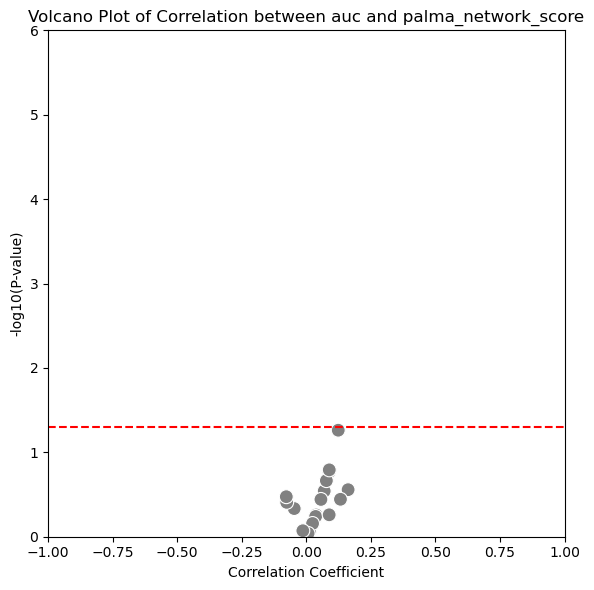

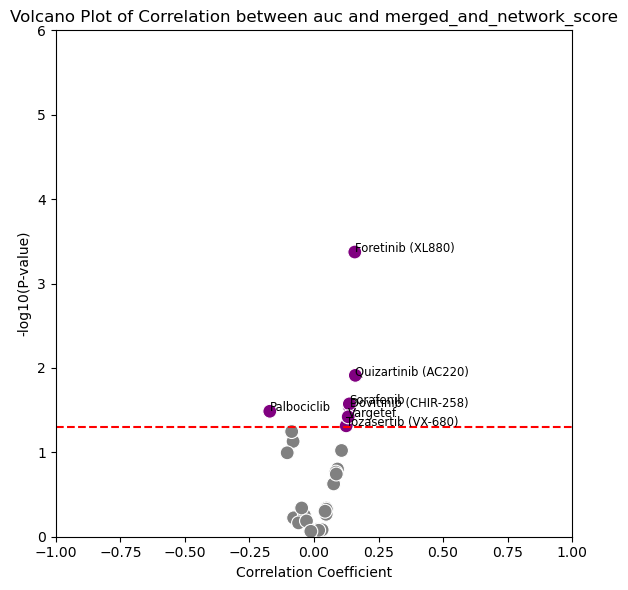

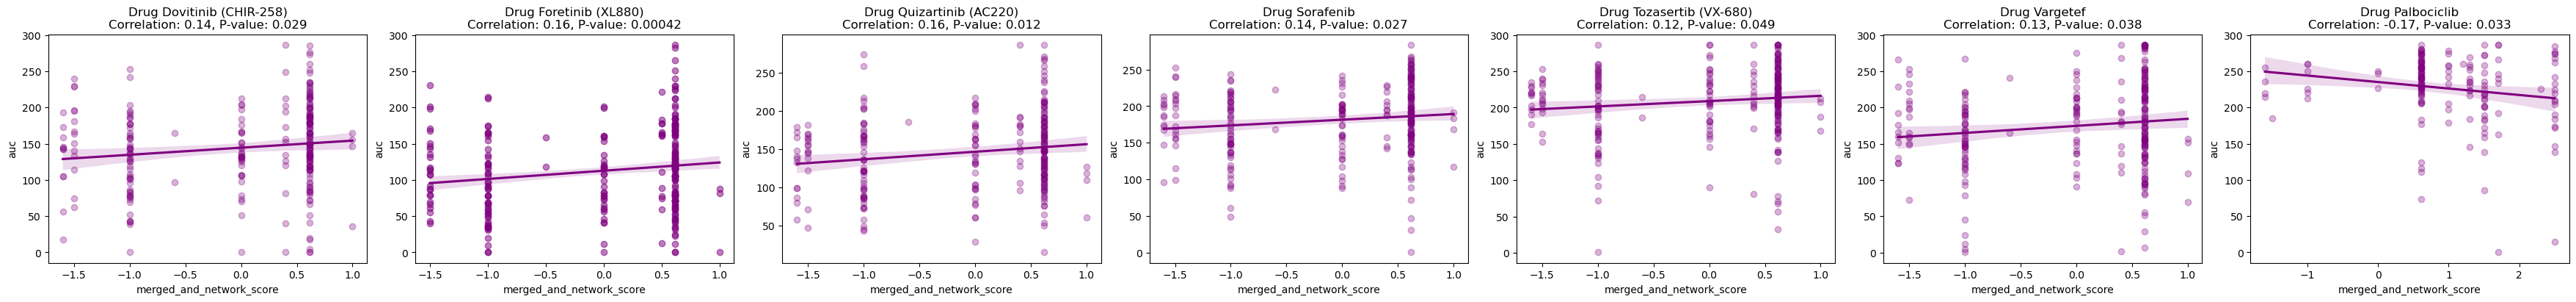

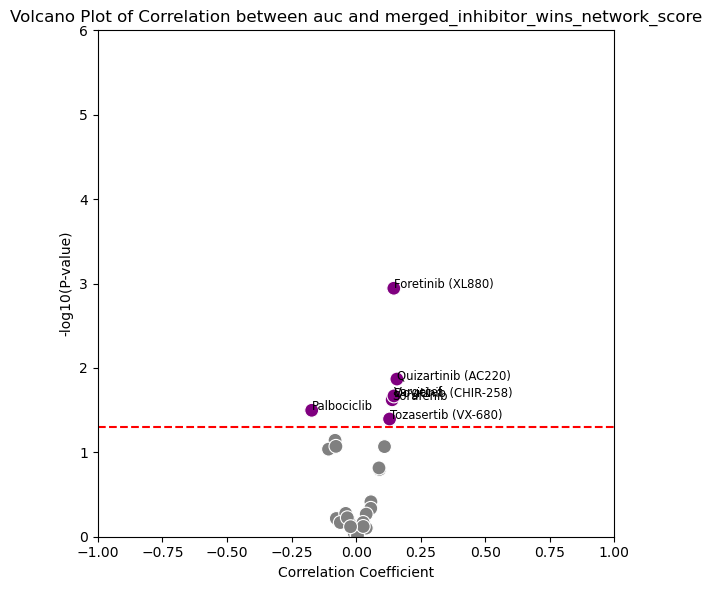

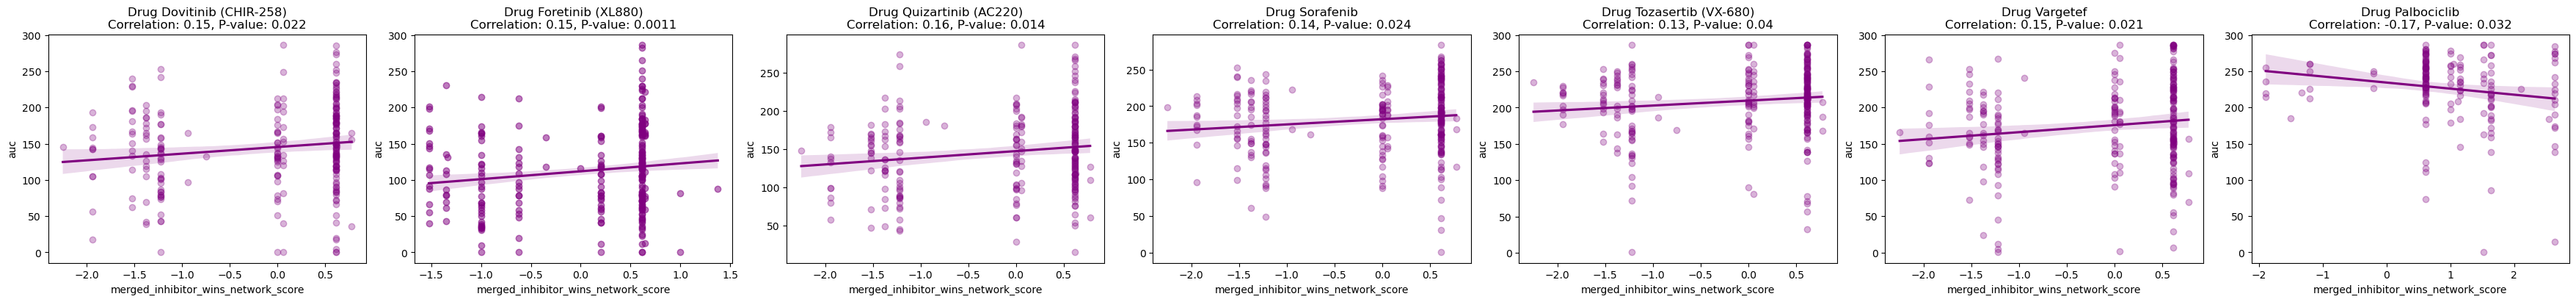

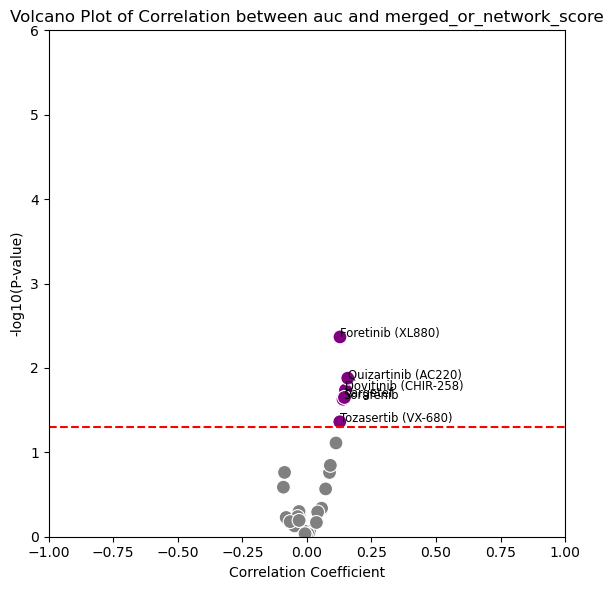

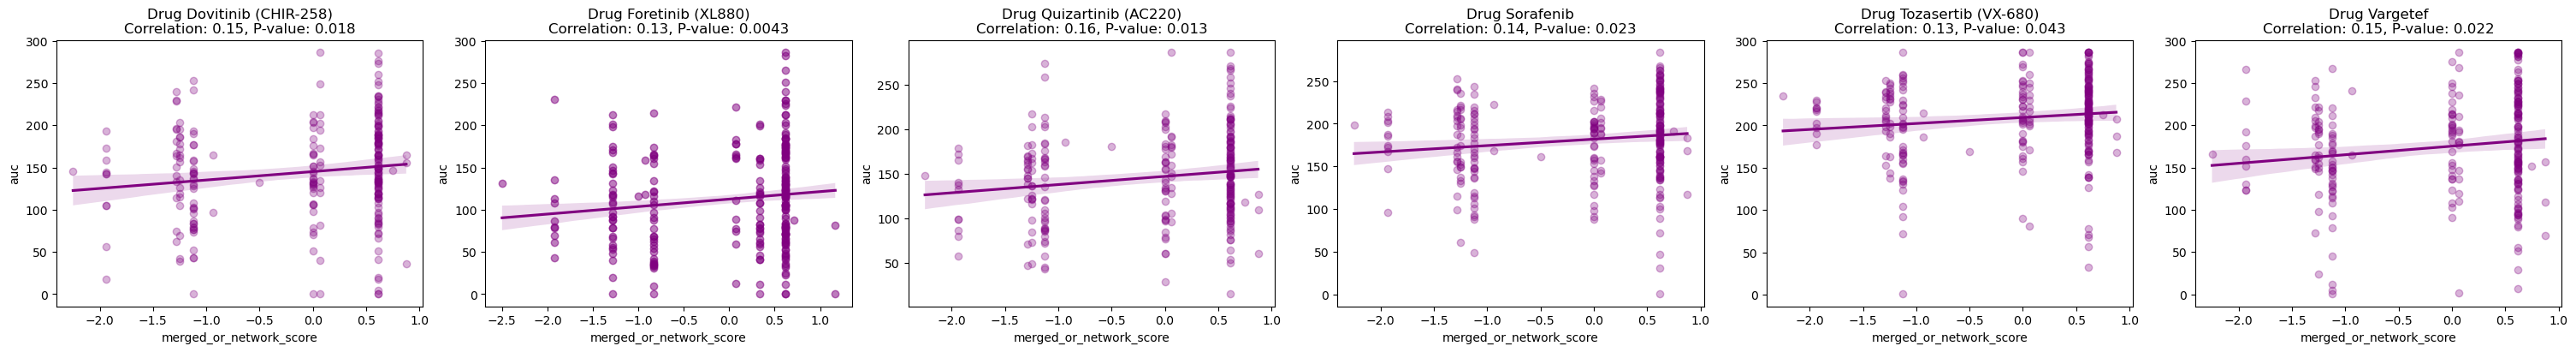

In [13]:
volcano_plot_per_drug('palma_network_score', 'auc')
volcano_plot_per_drug('merged_and_network_score', 'auc')
volcano_plot_per_drug('merged_inhibitor_wins_network_score', 'auc')
volcano_plot_per_drug('merged_or_network_score', 'auc')

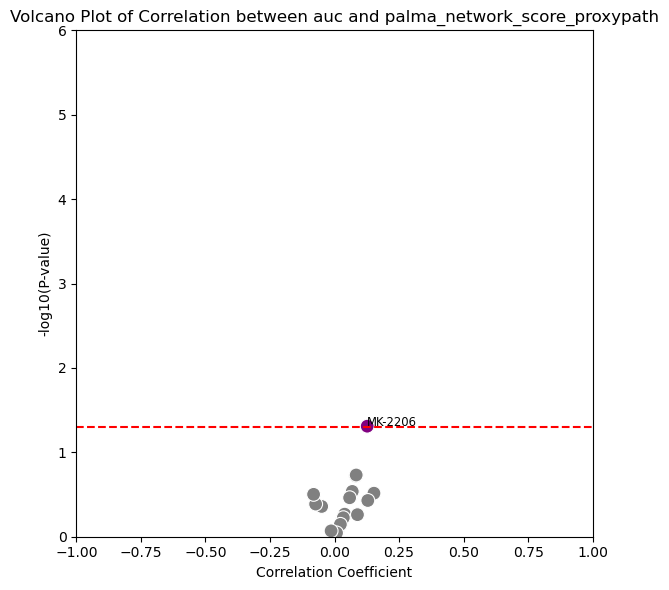

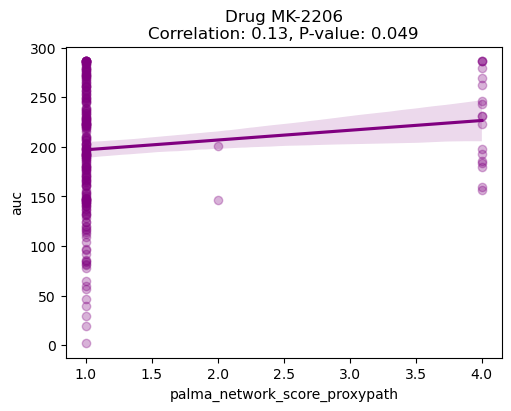

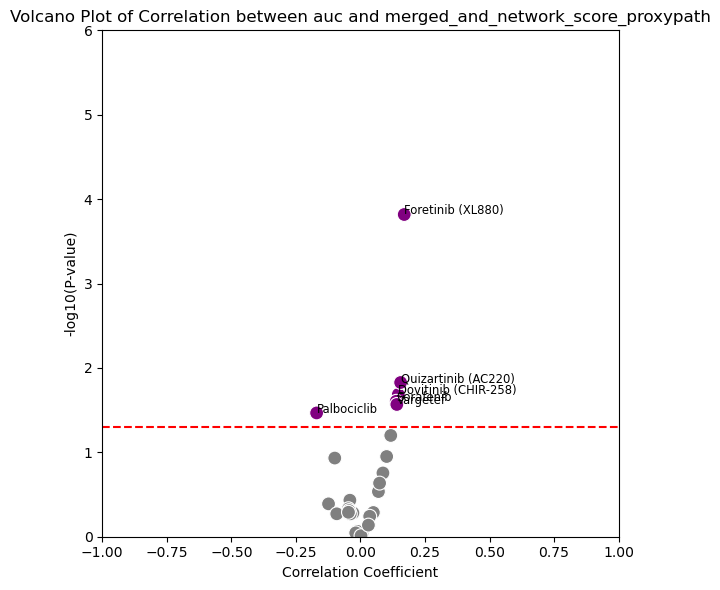

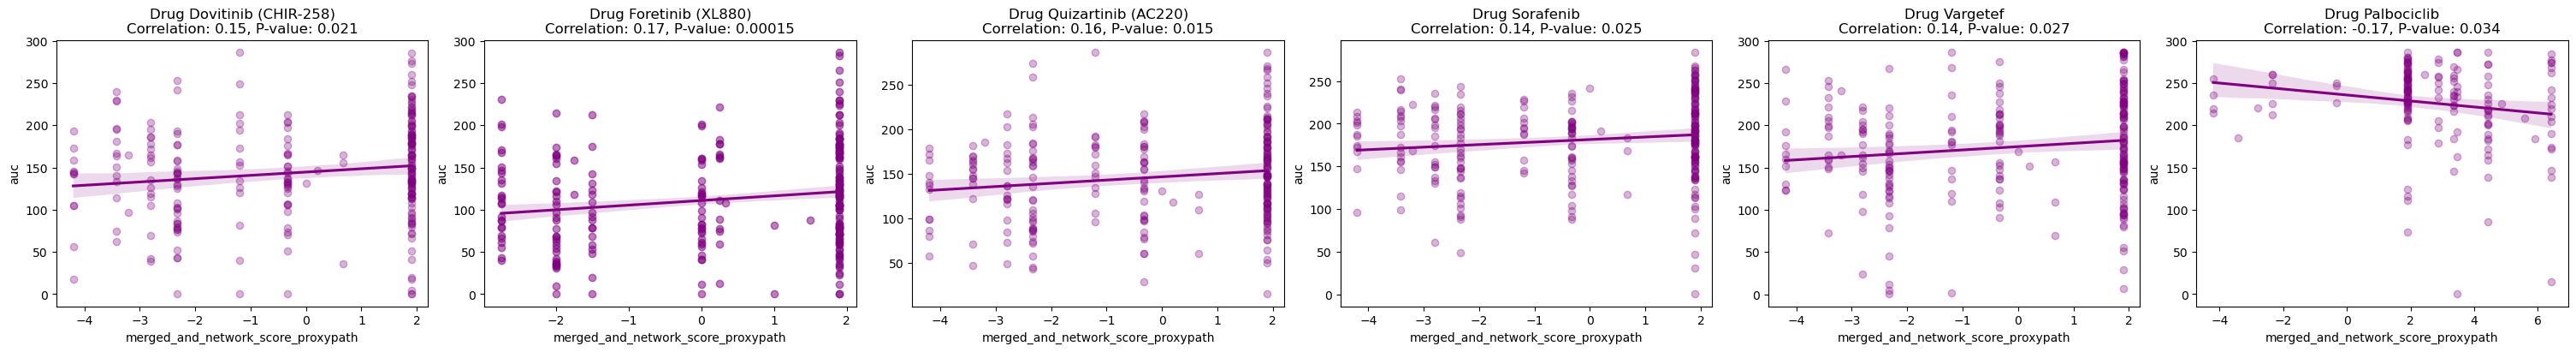

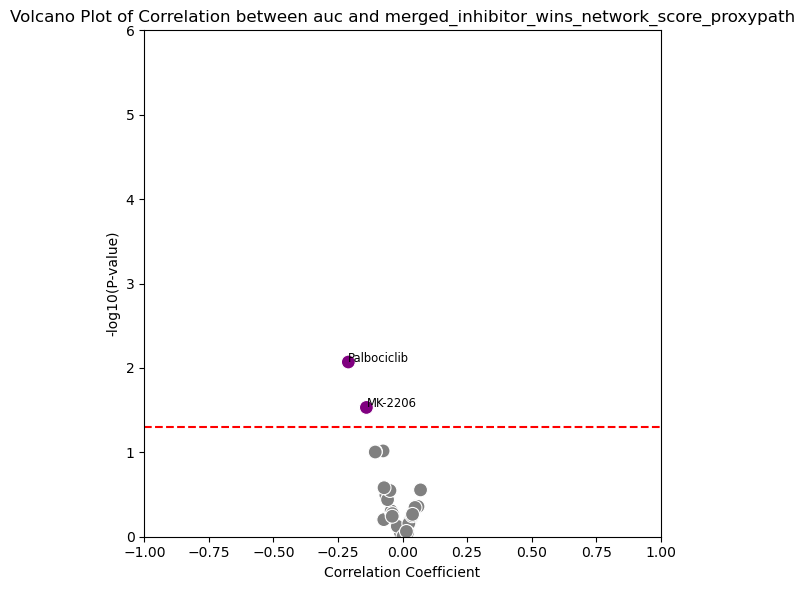

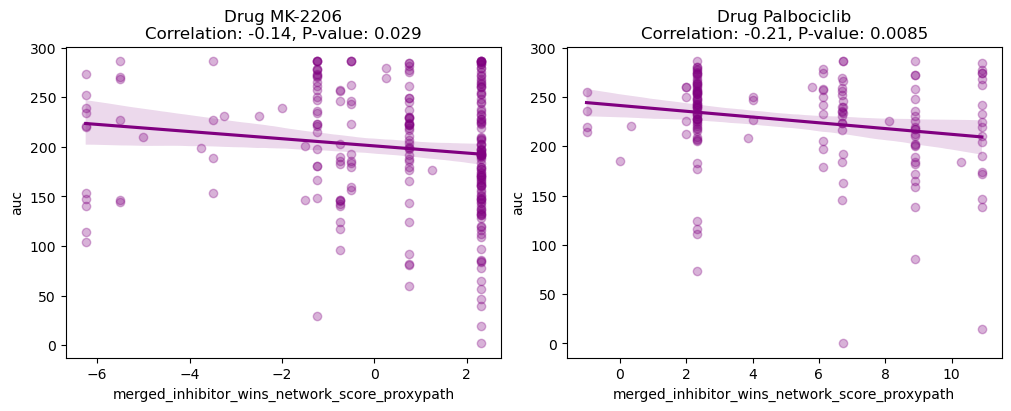

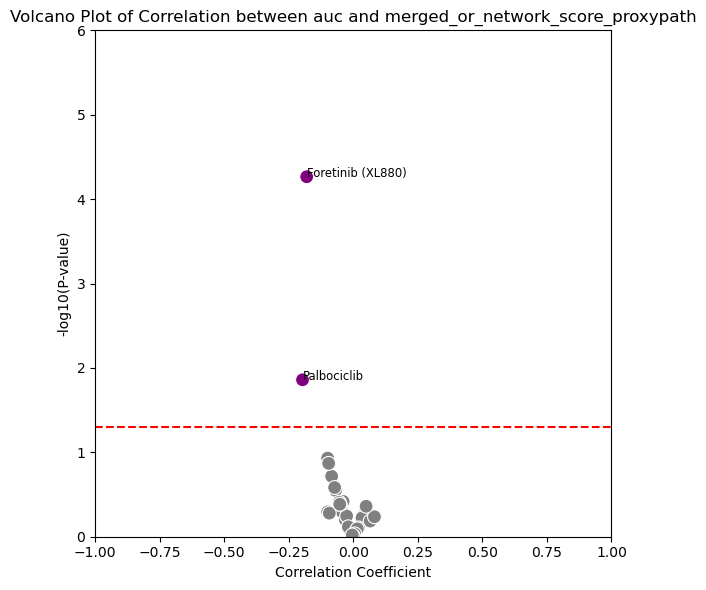

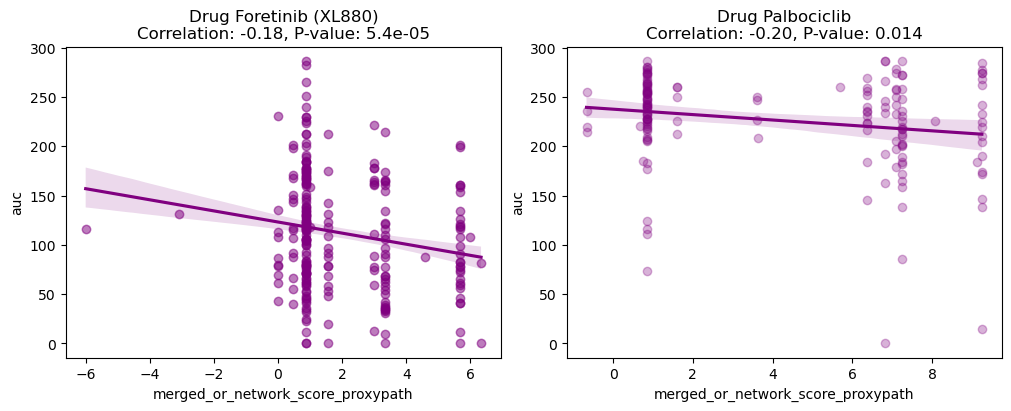

In [14]:
volcano_plot_per_drug('palma_network_score_proxypath', 'auc')
volcano_plot_per_drug('merged_and_network_score_proxypath', 'auc')
volcano_plot_per_drug('merged_inhibitor_wins_network_score_proxypath', 'auc')
volcano_plot_per_drug('merged_or_network_score_proxypath', 'auc')